# 1. Imports 

In [1]:
import os
import pandas as pd
from glob import glob
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import cohen_kappa_score, confusion_matrix
from PIL import Image
import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2
from tqdm import tqdm
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import timm
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

import seaborn as sns
import matplotlib.pyplot as plt

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.backends.cudnn.benchmark = True

# Constants
IMG_SIZE = 384
BATCH_SIZE = 16
EPOCHS = 10
NUM_CLASSES = 5
SEED = 42

# Reproducibility
torch.manual_seed(SEED)
np.random.seed(SEED)


# 2. Load

In [ ]:
# Load original labels
file_train_label = "/kaggle/input/diabetic-retinopathy-detection/trainLabels.csv.zip"
df = pd.read_csv(file_train_label)

# Retrieve image paths using glob
paths_train = sorted(glob('/kaggle/input/diabetic-retinopathy-train-unzipped/train/*.jpeg'))
df_paths = pd.DataFrame({
    'image': [os.path.basename(p).replace('.jpeg', '') for p in paths_train],
    'image_path': paths_train
})

# Merge image paths with label dataframe
df = df.merge(df_paths, on='image', how='left')

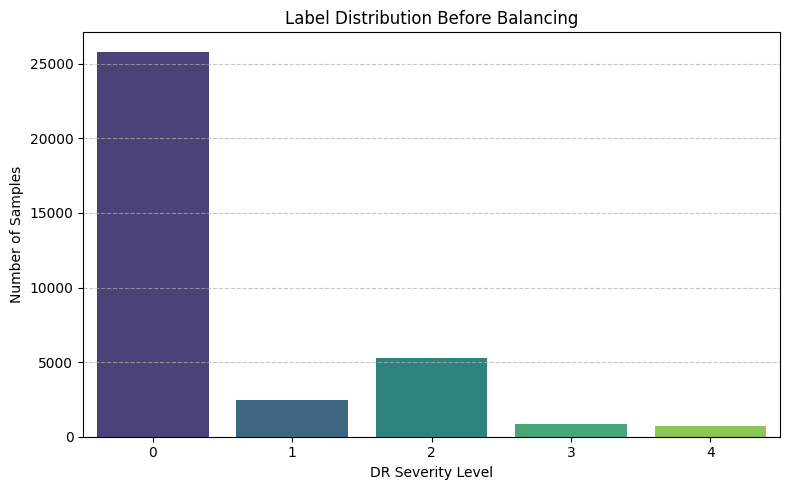

In [3]:
# Visualize original label distribution
def plot_class_distribution(df, title='Original Label Distribution'):
    plt.figure(figsize=(8, 5))
    sns.countplot(x='level', data=df, palette='viridis')
    plt.title(title)
    plt.xlabel("DR Severity Level")
    plt.ylabel("Number of Samples")
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

plot_class_distribution(df, title='Label Distribution Before Balancing')

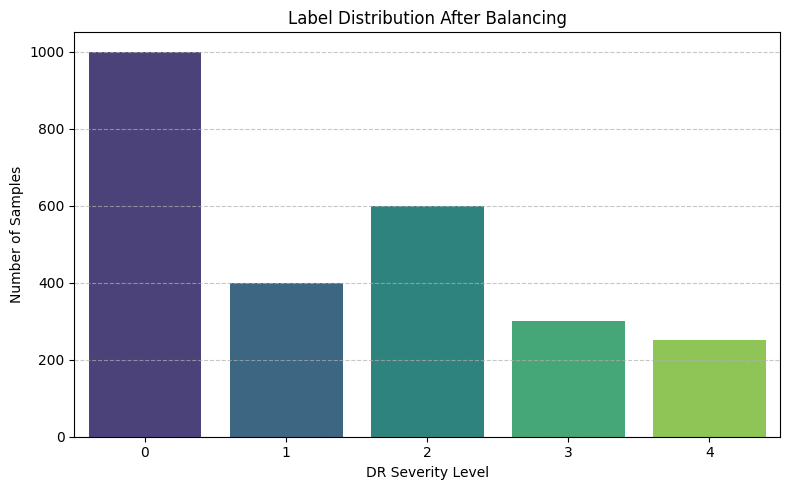

In [4]:
# Slightly balance the dataset by undersampling / controlled oversampling
samples_per_class = {
    0: 1000,
    1: 400,
    2: 600,
    3: 300,
    4: 250
}
df_balanced = pd.concat([
    df[df.level == i].sample(n=samples_per_class[i], replace=True, random_state=SEED)
    for i in samples_per_class
]).sample(frac=1, random_state=SEED).reset_index(drop=True)

# Stratified train/validation split to preserve class proportions
df_train, df_val = train_test_split(
    df_balanced,
    test_size=0.2,
    stratify=df_balanced['level'],
    random_state=SEED
)

plot_class_distribution(df_balanced, title='Label Distribution After Balancing')

# 3. Preprocessing + Augmentation + Dataset

In [5]:
# --- [Retina Image Preprocessing] ---
def preprocess_retina_clean(img_path, radius=300):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    height, width = img.shape[:2]
    scale = radius / (min(height, width) / 2)
    img = cv2.resize(img, (int(width * scale), int(height * scale)))

    # Mask low-value regions
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    mask = gray > gray.mean()
    img[~np.repeat(mask[:, :, np.newaxis], 3, axis=2)] = 128

    # Crop outer margins
    x_margin = img.shape[1] // 10
    y_margin = img.shape[0] // 10
    img = img[y_margin:-y_margin, x_margin:-x_margin]

    # Final resize to IMG_SIZE
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    return img

# --- [Albumentations Transforms] ---
train_transforms = A.Compose([
    A.LongestMaxSize(max_size=IMG_SIZE),
    A.PadIfNeeded(min_height=IMG_SIZE, min_width=IMG_SIZE, border_mode=cv2.BORDER_CONSTANT, value=128),
    A.CLAHE(p=0.3),
    A.GaussianBlur(p=0.2),
    A.RandomBrightnessContrast(p=0.5),
    A.HueSaturationValue(p=0.5),
    A.CoarseDropout(max_holes=8, max_height=16, max_width=16, p=0.3),
    A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15, p=0.5),
    A.HorizontalFlip(p=0.5),
    A.Normalize(),
    ToTensorV2()
])

val_transforms = A.Compose([
    A.LongestMaxSize(max_size=IMG_SIZE),
    A.PadIfNeeded(min_height=IMG_SIZE, min_width=IMG_SIZE, border_mode=cv2.BORDER_CONSTANT, value=128),
    A.Normalize(),
    ToTensorV2()
])

# --- [PyTorch Dataset] ---
class CleanRetinoDataset(Dataset):
    def __init__(self, df, transforms=None):
        self.df = df
        self.transforms = transforms
        self.has_labels = 'level' in df.columns

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img = preprocess_retina_clean(row.image_path)
        if self.transforms:
            img = self.transforms(image=img)["image"]
        if self.has_labels:
            return img, row.level
        return img

# --- [DataLoader Init] ---
train_ds = CleanRetinoDataset(df_train, transforms=train_transforms)
val_ds   = CleanRetinoDataset(df_val, transforms=val_transforms)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
val_loader   = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)


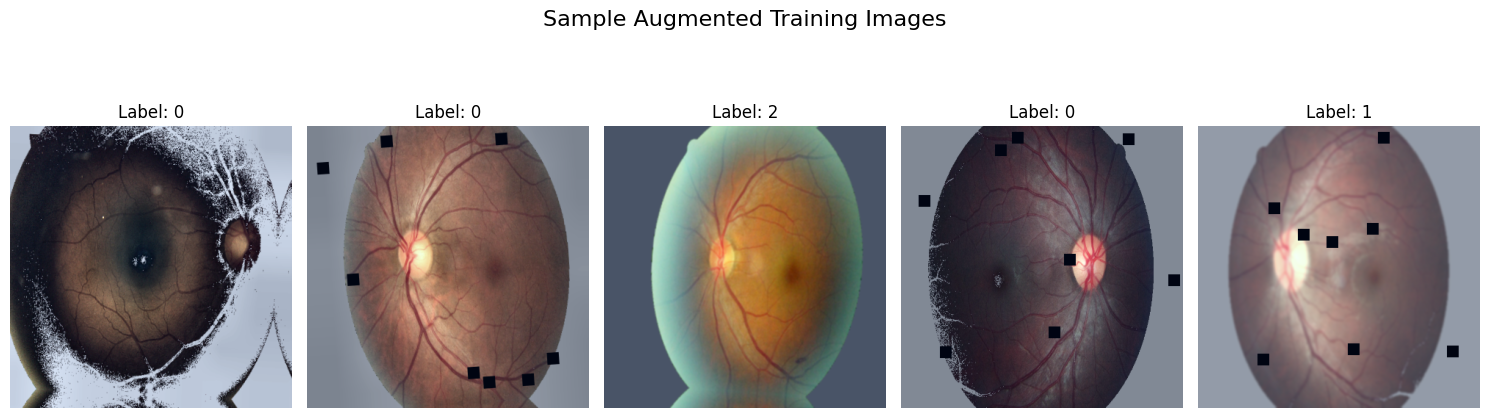

In [6]:
def show_augmented_images(dataset, num_images=5):
    plt.figure(figsize=(15, 5))
    for i in range(num_images):
        image, label = dataset[i]
        image = image.permute(1, 2, 0).cpu().numpy()  # [C, H, W] -> [H, W, C]
        image = (image - image.min()) / (image.max() - image.min())  # Normalize for display
        plt.subplot(1, num_images, i+1)
        plt.imshow(image)
        plt.title(f'Label: {label}')
        plt.axis('off')
    plt.suptitle("Sample Augmented Training Images", fontsize=16)
    plt.tight_layout()
    plt.show()

show_augmented_images(train_ds, num_images=5)


# 4. Model, Loss

In [7]:
# Create classification model with timm
def create_classification_model(model_name):
    model = timm.create_model(model_name, pretrained=True, num_classes=NUM_CLASSES)
    return model

# Loss function: CrossEntropyLoss for multi-class classification
criterion = nn.CrossEntropyLoss()

# Prediction function (returns predicted class)
def predict_from_logits(logits):
    return torch.argmax(logits, dim=1)


In [8]:
model_names = {
    #"efficientnet": "efficientnet_b0",
    "convnext_base": "convnext_base.fb_in22k",
    "swin_base": "swin_base_patch4_window12_384",
}

In [9]:
def train_and_eval_ce(model_name, patience=3):
    model = create_classification_model(model_names[model_name]).to(device)

    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=1)
    scaler = torch.cuda.amp.GradScaler()

    best_kappa = -np.inf
    no_improve_epochs = 0

    for epoch in range(EPOCHS):
        model.train()
        train_preds, train_targets = [], []
        train_loss_total = 0.0

        for x, y in tqdm(train_loader, desc=f"{model_name} Epoch {epoch+1}"):
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            with torch.cuda.amp.autocast():
                logits = model(x)
                loss = criterion(logits, y)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            train_loss_total += loss.item()
            train_preds.extend(predict_from_logits(logits).detach().cpu().numpy())
            train_targets.extend(y.detach().cpu().numpy())

        train_kappa = cohen_kappa_score(train_targets, train_preds, weights='quadratic')

        # Validation
        model.eval()
        val_preds, val_targets = [], []
        val_loss_total = 0.0
        with torch.no_grad():
            for x, y in val_loader:
                x, y = x.to(device), y.to(device)
                logits = model(x)
                val_loss_total += criterion(logits, y).item()
                val_preds.extend(predict_from_logits(logits).cpu().numpy())
                val_targets.extend(y.cpu().numpy())

        val_kappa = cohen_kappa_score(val_targets, val_preds, weights='quadratic')
        print(f"{model_name} Epoch {epoch+1} - Train QWK: {train_kappa:.4f} | Val QWK: {val_kappa:.4f}")
        scheduler.step(val_kappa)

        # Save best model
        if val_kappa > best_kappa:
            torch.save(model.state_dict(), f"{model_name}_best.pth")
            best_kappa = val_kappa
            no_improve_epochs = 0
            print(f"Saved best model for {model_name}")
        else:
            no_improve_epochs += 1
            if no_improve_epochs >= patience:
                print(f"Early stopping {model_name} at epoch {epoch+1}")
                break

    return best_kappa


In [10]:
model_scores = {}
for model_id in model_names:
    print(f"\n Training model: {model_id}")
    model_scores[model_id] = train_and_eval_ce(model_id)


 Training model: convnext_base


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

convnext_base Epoch 1: 100%|██████████| 128/128 [03:01<00:00,  1.42s/it]


convnext_base Epoch 1 - Train QWK: 0.2196 | Val QWK: 0.6023
Saved best model for convnext_base


convnext_base Epoch 2: 100%|██████████| 128/128 [02:43<00:00,  1.28s/it]


convnext_base Epoch 2 - Train QWK: 0.6262 | Val QWK: 0.7354
Saved best model for convnext_base


convnext_base Epoch 3: 100%|██████████| 128/128 [02:43<00:00,  1.28s/it]


convnext_base Epoch 3 - Train QWK: 0.7384 | Val QWK: 0.7344


convnext_base Epoch 4: 100%|██████████| 128/128 [02:43<00:00,  1.28s/it]


convnext_base Epoch 4 - Train QWK: 0.7749 | Val QWK: 0.7226


convnext_base Epoch 5: 100%|██████████| 128/128 [02:43<00:00,  1.28s/it]


convnext_base Epoch 5 - Train QWK: 0.8569 | Val QWK: 0.7575
Saved best model for convnext_base


convnext_base Epoch 6: 100%|██████████| 128/128 [02:43<00:00,  1.28s/it]


convnext_base Epoch 6 - Train QWK: 0.8873 | Val QWK: 0.7511


convnext_base Epoch 7: 100%|██████████| 128/128 [02:43<00:00,  1.27s/it]


convnext_base Epoch 7 - Train QWK: 0.9130 | Val QWK: 0.7948
Saved best model for convnext_base


convnext_base Epoch 8: 100%|██████████| 128/128 [02:43<00:00,  1.27s/it]


convnext_base Epoch 8 - Train QWK: 0.9412 | Val QWK: 0.7294


convnext_base Epoch 9: 100%|██████████| 128/128 [02:43<00:00,  1.28s/it]


convnext_base Epoch 9 - Train QWK: 0.9656 | Val QWK: 0.7788


convnext_base Epoch 10: 100%|██████████| 128/128 [02:42<00:00,  1.27s/it]


convnext_base Epoch 10 - Train QWK: 0.9773 | Val QWK: 0.8040
Saved best model for convnext_base

 Training model: swin_base


model.safetensors:   0%|          | 0.00/365M [00:00<?, ?B/s]

swin_base Epoch 1: 100%|██████████| 128/128 [02:26<00:00,  1.15s/it]


swin_base Epoch 1 - Train QWK: 0.3097 | Val QWK: 0.5386
Saved best model for swin_base


swin_base Epoch 2: 100%|██████████| 128/128 [02:25<00:00,  1.14s/it]


swin_base Epoch 2 - Train QWK: 0.5914 | Val QWK: 0.5339


swin_base Epoch 3: 100%|██████████| 128/128 [02:26<00:00,  1.14s/it]


swin_base Epoch 3 - Train QWK: 0.6509 | Val QWK: 0.6307
Saved best model for swin_base


swin_base Epoch 4: 100%|██████████| 128/128 [02:27<00:00,  1.16s/it]


swin_base Epoch 4 - Train QWK: 0.6980 | Val QWK: 0.7075
Saved best model for swin_base


swin_base Epoch 5: 100%|██████████| 128/128 [02:25<00:00,  1.14s/it]


swin_base Epoch 5 - Train QWK: 0.7208 | Val QWK: 0.7325
Saved best model for swin_base


swin_base Epoch 6: 100%|██████████| 128/128 [02:26<00:00,  1.15s/it]


swin_base Epoch 6 - Train QWK: 0.7341 | Val QWK: 0.6971


swin_base Epoch 7: 100%|██████████| 128/128 [02:25<00:00,  1.14s/it]


swin_base Epoch 7 - Train QWK: 0.7594 | Val QWK: 0.6682


swin_base Epoch 8: 100%|██████████| 128/128 [02:26<00:00,  1.15s/it]


swin_base Epoch 8 - Train QWK: 0.8072 | Val QWK: 0.7140
Early stopping swin_base at epoch 8


In [11]:
# === Ensemble on Validation Set

def ensemble_predict_val():
    models = {}
    for name in model_names:
        model = create_classification_model(model_names[name])
        model.load_state_dict(torch.load(f"{name}_best.pth"))
        model.to(device)
        model.eval()
        models[name] = model

    all_preds, all_labels = [], []

    with torch.no_grad():
        for x, y in val_loader:
            x = x.to(device)
            logits_sum = torch.zeros((x.size(0), NUM_CLASSES), device=device)

            for model in models.values():
                with torch.cuda.amp.autocast():
                    logits = model(x)
                    logits_sum += logits

            avg_logits = logits_sum / len(models)
            preds = predict_from_logits(avg_logits).cpu().numpy()

            all_preds.extend(preds)
            all_labels.extend(y.numpy())

    qwk = cohen_kappa_score(all_labels, all_preds, weights='quadratic')
    print(f"\n Ensemble QWK on Validation: {qwk:.4f}")
    return qwk

# Run ensemble on validation
ensemble_qwk_val = ensemble_predict_val()



 Ensemble QWK on Validation: 0.8072


# 5. TEST SET INFERENCE

In [12]:
test_paths = sorted(glob('/kaggle/input/diabetic-retinopathy-test-unzipped/test/*.jpeg'))
test_df = pd.DataFrame({
    'image': [os.path.basename(p).split('.')[0] for p in test_paths],
    'image_path': test_paths
})

def create_model_entropy(model_name):
    base = timm.create_model(model_names[model_name], pretrained=True, num_classes=NUM_CLASSES)
    return base

def predict_ensemble_test_entropy(test_df, tta_times=4):
    models = {}
    for name in model_names:
        model = create_model_entropy(name)
        model.load_state_dict(torch.load(f"{name}_best.pth"))
        model.to(device)
        model.eval()
        models[name] = model

    test_ds = CleanRetinoDataset(test_df, transforms=val_transforms)
    test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False)

    all_preds = []

    with torch.no_grad():
        for x in tqdm(test_loader, desc="TTA Ensemble Inference (Entropy)"):
            x = x.to(device)

            # Init logits: [batch_size, num_classes]
            logits = torch.zeros((x.size(0), NUM_CLASSES), device=device)

            for _ in range(tta_times):
                aug_x = x  # apply TTA transforms here if needed
                for model in models.values():
                    with torch.cuda.amp.autocast():
                        logits += model(aug_x)

            logits /= (tta_times * len(models))
            preds = logits.argmax(dim=1).cpu().numpy()
            all_preds.extend(preds)

    submission = pd.DataFrame({'image': test_df.image, 'level': all_preds})
    submission.to_csv("submission.csv", index=False)
    print("Submission file saved: submission.csv")

predict_ensemble_test_entropy(test_df)

TTA Ensemble Inference (Entropy): 100%|██████████| 3349/3349 [4:55:22<00:00,  5.29s/it]

Submission file saved: submission.csv
